Tomaremos o melhor modelo para detectar a ocorrencia de fraude e tentaremos melhorá-lo incluindo mais camadas na rede.



In [ ]:
#Importando bibliotecas
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

In [ ]:
credit_tl = pd.read_csv('credit_tl.csv') #Dados que passaram por TOMEK LINKS
credit_tl.drop(columns = [credit_tl.columns[0],credit_tl.columns[1]], inplace=True)

credit_test = pd.read_csv('credit_teste.csv') # Conjunto de teste
credit_test.drop(columns=[credit_test.columns[0],credit_test.columns[1]],inplace=True)

X_test, X_val, y_test, y_val = train_test_split(credit_test.iloc[:,:-1],credit_test.iloc[:,-1], test_size =0.2)  #Dividindo conjunto de teste em teste e validação para usar futuramente no treinamento do modelo

# Dividindo cada conjunto de dados em X e Y
X_tl, y_tl = credit_tl.iloc[:,:-1], credit_tl.iloc[:,-1]

In [ ]:
scaler_tl = StandardScaler() # Normalizando os dados para terem média 0 e desvio padrão 1

X_tl_train = scaler_tl.fit_transform(X_tl)
X_test_tl = scaler_tl.transform(X_test)
X_val_tl = scaler_tl.transform(X_val)

print(f'Quantidade de registro em X_tl_train: {X_tl_train.shape[0]}')

Quantidade de registro em X_tl_train: 227828


# Definindo parâmetros úteis para os modelos

In [ ]:
# Definindo métricas para o modelo

metricas = [
    keras.metrics.TruePositives(name='VV'),
    keras.metrics.TrueNegatives(name='VN'),
    keras.metrics.FalsePositives(name='FP'),
    keras.metrics.FalseNegatives(name='FN'),
    keras.metrics.BinaryAccuracy(name='acurácia'),
    keras.metrics.Precision(name='Precisão'),
    keras.metrics.Recall(name='Recall'),
    keras.metrics.AUC(name='AUC'),
    keras.metrics.AUC(name='PRC',curve='PR')
]

# Definindo Modelo

def make_model(metrics = metricas, output_bias=None):
  if output_bias is not None:
    output_bias = keras.initializer.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Flatten(),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(100, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid', bias_initializer = output_bias)
  ])

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-3),
                loss = keras.losses.BinaryCrossentropy(),
                metrics=metrics)
  
  return model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_PRC',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights = True
)

# Definindo funções para analisar as métricas

In [ ]:
# Definindo função para plotar metricas

def plot_metrics(history):
  metrics = ['loss','PRC','Precisão','Recall']
  for n,metric in enumerate(metrics):
    name = metric.replace('_',' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label = 'Train')
    plt.plot(history.epoch, history.history['val_'+metric], label='Val',linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Plota matriz de confusão

def plot_matriz_conf(y, y_hat,p=0.5):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y, y_hat>p)
    sns.heatmap(cm, annot=True)
    plt.ylabel('Rótulos verdadeiros')
    plt.xlabel('Rótulos previstos')
    plt.xticks([.5,1.5],['Não Houve fraude','houve fraude'], rotation=0)
    plt.yticks([0.5,1.5],['Não Houve fraude','houve fraude'],rotation=0)
    plt.title('Matriz de Confusão')
  
# Função para plotar ROC

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth = 2, **kwargs)
  plt.xlabel('Falso Positivo [%]')
  plt.ylabel('Verdadeiro Positivo [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Função para plotar curva PR

def plot_prc(name, labels,predictions, **kwargs):
  precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

  plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
  plt.xlabel('Precisão')
  plt.ylabel('Recall')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Função para plotar curva PR

def plot_prc(name, labels,predictions, **kwargs):
  precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

  plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
  plt.xlabel('Precisão')
  plt.ylabel('Recall')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# Treinando e analisando modelo

In [ ]:
# Calculando quantidade de rótulos negativos e positivos
credit_df = pd.read_csv('creditcard.csv')
neg, pos = np.bincount(credit_df['Class'])
total = neg+pos

# Modificando peso do modelo para dar mais atenção ao caso fraudulento 

peso_0 = (1/neg)*(total/2)
peso_1 = (1/pos)*(total/2)

class_weight = {0:peso_0, 1:peso_1}

print(f'O peso da classe 0 será {peso_0}')
print(f'O peso da classe 1 será {peso_1}')


O peso da classe 0 será 0.5008652375006595
O peso da classe 1 será 289.43800813008136


In [ ]:
# Treinando para os dados que sofreram Tomek Links
weighted_model_tl = make_model()
EPOCHS = 100

history_tl = weighted_model_tl.fit(
    X_tl_train,
    y_tl,
    epochs = EPOCHS,
    callbacks = [early_stopping],
    validation_data = (X_val_tl,y_val),
    class_weight = class_weight
)

Epoch 1/100
7120/7120 [==============================] - 59s 7ms/step - loss: 2.9351 - VV: 290.0000 - VN: 200327.0000 - FP: 27106.0000 - FN: 105.0000 - acurácia: 0.8806 - Precisão: 0.0106 - Recall: 0.7342 - AUC: 0.8464 - PRC: 0.0711 - val_loss: 0.1108 - val_VV: 17.0000 - val_VN: 10757.0000 - val_FP: 616.0000 - val_FN: 3.0000 - val_acurácia: 0.9457 - val_Precisão: 0.0269 - val_Recall: 0.8500 - val_AUC: 0.9744 - val_PRC: 0.8059
Epoch 2/100
7120/7120 [==============================] - 45s 6ms/step - loss: 1.3594 - VV: 319.0000 - VN: 206441.0000 - FP: 20992.0000 - FN: 76.0000 - acurácia: 0.9075 - Precisão: 0.0150 - Recall: 0.8076 - AUC: 0.9067 - PRC: 0.1028 - val_loss: 0.0266 - val_VV: 16.0000 - val_VN: 11343.0000 - val_FP: 30.0000 - val_FN: 4.0000 - val_acurácia: 0.9970 - val_Precisão: 0.3478 - val_Recall: 0.8000 - val_AUC: 0.9666 - val_PRC: 0.6830
Epoch 3/100
7120/7120 [==============================] - 48s 7ms/step - loss: 2.9000 - VV: 294.0000 - VN: 206096.0000 - FP: 21337.0000 - FN: 1

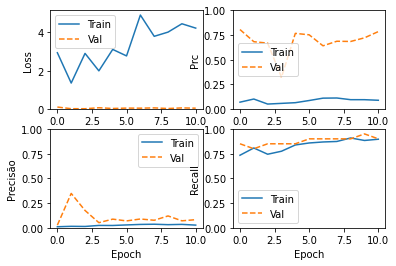

In [ ]:
#Plotando o valor das métricas por época
plot_metrics(history_tl) 

O uso do earliestopping fez o modelo parar antes de completar as 100 épocas, pelo gráfico da loss o modelo não convergiu para uma loss menor ao longo das épocas. Esse não é um modelo confiável, não poderemos usá-lo como o melhor modelo. Seguirimos, porém, com a análise de outras métricas.

1425/1425 [==============================] - 6s 4ms/step - loss: 0.1168 - VV: 72.0000 - VN: 42877.0000 - FP: 2615.0000 - FN: 5.0000 - acurácia: 0.9425 - Precisão: 0.0268 - Recall: 0.9351 - AUC: 0.9697 - PRC: 0.6529
loss : 0.1168166920542717
VV : 72.0
VN : 42877.0
FP : 2615.0
FN : 5.0
acurácia : 0.9425047636032104
Precisão : 0.026795683428645134
Recall : 0.9350649118423462
AUC : 0.9697063565254211
PRC : 0.6528600454330444



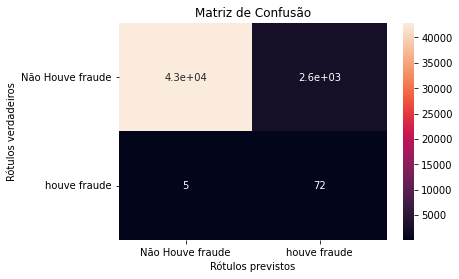

In [ ]:
#Fazendo previsões
train_predictions_model = weighted_model_tl.predict(X_tl_train)
test_predictions_model = weighted_model_tl.predict(X_test_tl)

model_tl_result = weighted_model_tl.evaluate(X_test_tl, y_test)

#Escrevendo valores úteis
for name, value in zip(weighted_model_tl.metrics_names, model_tl_result):
  print(f'{name} : {value}')

#Plotando matriz de confusão
print()
plot_matriz_conf(y_test, test_predictions_model) 

Esse foi o melhor modelo quando consideramos apenas o recall, porém essa rede não foi muito treinada, provavelmente essa é a rede com os pesos após o fim da primeira época. Ela apresenta baixa precisão, com o uso de outras técnicas, esse modelo poderia ser útil. Seria necessário buscar melhores formas de convergência para termos um modelo confiável.

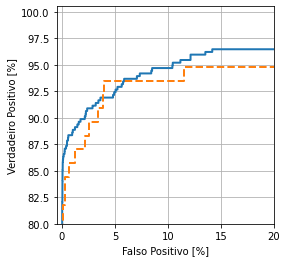

In [ ]:
#Plotando curva roc
plot_roc('Conjunto de treino', y_tl, train_predictions_model)
plot_roc('Conjunto de teste', y_test, test_predictions_model, linestyle = '--')

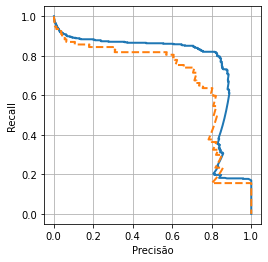

In [ ]:
#Plotando curva prc
plot_prc('Conjunto de treino', y_tl, train_predictions_model)
plot_prc('Conjunto de teste', y_test, test_predictions_model, linestyle = '--')